# ADDIKAH SYDNEY MAKUNDA
# 21/03313
# Assignment four - Predictive Analytics
# Predicting IBM stock prices
# Data source: kaggle
# Importing The Necessary Libraries and Loading The Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
# Necessary code that will aid in data visualization
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
data=pd.read_csv('C:/Datafiles/AABA_File.csv', index_col='Date', parse_dates=['Date'])
print('The shape of the dataframe is :\n',data.shape)
print(data)

The shape of the dataframe is :
 (3019, 6)
             Open   High    Low  Close    Volume  Name
Date                                                  
2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
...           ...    ...    ...    ...       ...   ...
2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA

[3019 rows x 6 columns]


### Selecting training and test data. Selected 2006 to 2016 data range as training data and 2017 and beyond as test data

In [4]:
training_set = data[:'2016'].iloc[:,1:2].values
test_set = data['2017':].iloc[:,1:2].values

### Test with "High" price attribute and display the trend over the years

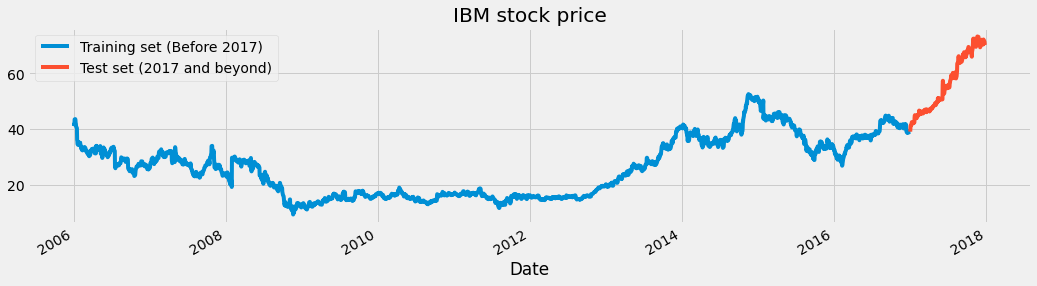

In [5]:
data["High"][:'2016'].plot(figsize=(16,4),legend=True)
data["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

## Preprocess the train and test data

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# create a data structure with 60 timesteps and 1 output since LSTMs store long term memory state
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## Create LSTM architecture by creating layers, compiling the RNN and training the data set

In [9]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 16s 107ms/step - loss: 0.0154
Epoch 2/50
85/85 [==============================] - 9s 105ms/step - loss: 0.0072
Epoch 3/50
85/85 [==============================] - 9s 108ms/step - loss: 0.0058
Epoch 4/50
85/85 [==============================] - 10s 112ms/step - loss: 0.0046
Epoch 5/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0042
Epoch 6/50
85/85 [==============================] - 10s 112ms/step - loss: 0.0040
Epoch 7/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0034
Epoch 8/50
85/85 [==============================] - 9s 109ms/step - loss: 0.0032
Epoch 9/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0029
Epoch 10/50
85/85 [==============================] - 9s 109ms/step - loss: 0.0026
Epoch 11/50
85/85 [==============================] - 9s 111ms/step - loss: 0.0028
Epoch 12/50
85/85 [==============================] - 9s 105ms/step - loss: 0.0024
Epoch 13/50
85/85 [==

### Create array to hold stock

In [10]:
# Get Test set ready same way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
data_total = pd.concat((data["High"][:'2016'],data["High"]['2017':]),axis=0)
inputs = data_total[len(data_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [11]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

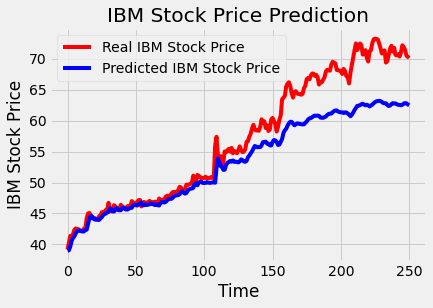

In [12]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [13]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.796115576083181.


### The LSTM model architecture has a root mean squared error of 4.724768468613017 as shown above. The error size is somehow big as can be shown by the gap in the trend chart

# Create GRU architecture by creating layers, compiling the RNN and predicting the prices

In [14]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

C:\Users\kilym\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
19/19 [==============================] - 12s 238ms/step - loss: 0.0702
Epoch 2/50
19/19 [==============================] - 5s 236ms/step - loss: 0.0252
Epoch 3/50
19/19 [==============================] - 5s 252ms/step - loss: 0.0066
Epoch 4/50
19/19 [==============================] - 5s 240ms/step - loss: 0.0036
Epoch 5/50
19/19 [==============================] - 4s 231ms/step - loss: 0.0030
Epoch 6/50
19/19 [==============================] - 4s 234ms/step - loss: 0.0030
Epoch 7/50
19/19 [==============================] - 5s 242ms/step - loss: 0.0029
Epoch 8/50
19/19 [==============================] - 5s 268ms/step - loss: 0.0029
Epoch 9/50
19/19 [==============================] - 5s 244ms/step - loss: 0.0027
Epoch 10/50
19/19 [==============================] - 5s 250ms/step - loss: 0.0025
Epoch 11/50
19/19 [==============================] - 6s 311ms/step - loss: 0.0028
Epoch 12/50
19/19 [==============================] - 6s 294ms/step - loss: 0.0026
Epoch 13/50
19/19 [=====

In [15]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

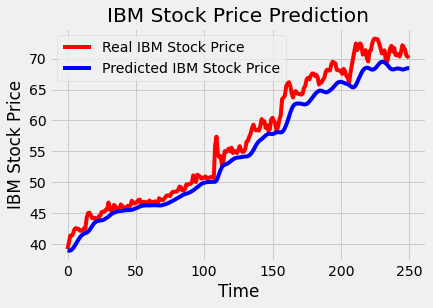

In [16]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [17]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 2.4523750748617146.


### The GRU model architecture has a root mean squared error of 2.383560688346273 as shown above. The error size is less than that for LSTM and in this case gives a better prediction as can be seen in the trendline graph